# Modifying the scene

In [2]:
import numpy as np
import mujoco
import mediapy as media
import matplotlib.pyplot as plt
import time
np.random.seed(0)
import itertools

""

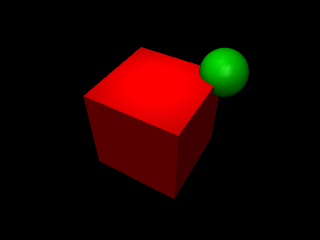

In [4]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
renderer = mujoco.Renderer(model)
data = mujoco.MjData(model)

mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

In [5]:
def get_geom_speed(model, data, geom_name):
  """Returns the speed of a geom."""
  geom_vel = np.zeros(6)
  geom_type = mujoco.mjtObj.mjOBJ_GEOM
  geom_id = data.geom(geom_name).id
  mujoco.mj_objectVelocity(model, data, geom_type, geom_id, geom_vel, 0)
  return np.linalg.norm(geom_vel)

def add_visual_capsule(scene, point1, point2, radius, rgba):
  """Adds one capsule to an mjvScene."""
  if scene.ngeom >= scene.maxgeom:
    return
  scene.ngeom += 1  # increment ngeom
  # initialise a new capsule, add it to the scene using mjv_makeConnector
  mujoco.mjv_initGeom(scene.geoms[scene.ngeom-1],
                      mujoco.mjtGeom.mjGEOM_CAPSULE, np.zeros(3),
                      np.zeros(3), np.zeros(9), rgba.astype(np.float32))
  mujoco.mjv_makeConnector(scene.geoms[scene.ngeom-1],
                           mujoco.mjtGeom.mjGEOM_CAPSULE, radius,
                           point1[0], point1[1], point1[2],
                           point2[0], point2[1], point2[2])

 # traces of time, position and speed
times = []
positions = []
speeds = []
offset = model.jnt_axis[0]/16  # offset along the joint axis

def modify_scene(scn):
  """Draw position trace, speed modifies width and colors."""
  if len(positions) > 1:
    for i in range(len(positions)-1):
      rgba=np.array((np.clip(speeds[i]/10, 0, 1),
                     np.clip(1-speeds[i]/10, 0, 1),
                     .5, 1.))
      radius=.003*(1+speeds[i])
      point1 = positions[i] + offset*times[i]
      point2 = positions[i+1] + offset*times[i+1]
      add_visual_capsule(scn, point1, point2, radius, rgba)

duration = 6    # (seconds)
framerate = 30  # (Hz)

# Simulate and display video.
frames = []

# Reset state and time.
mujoco.mj_resetData(model, data)
mujoco.mj_forward(model, data)

while data.time < duration:
  # append data to the traces
  positions.append(data.geom_xpos[data.geom("green_sphere").id].copy())
  times.append(data.time)
  speeds.append(get_geom_speed(model, data, "green_sphere"))
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    modify_scene(renderer.scene)
    pixels = renderer.render()
    frames.append(pixels)
media.show_video(frames, fps=framerate)